# Import

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import itertools
import keras
import keras_tuner as kt

from random import gauss
from random import seed

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, root_mean_squared_error,r2_score

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from arch import arch_model

from pmdarima import auto_arima
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from keras_tuner import Hyperband
from keras.models import load_model,Sequential

In [3]:
df = pd.read_csv('../data/cleaned_data/master.csv',index_col=0)
df.head(40)

,nonglu_price,hommali_price,agri_prod_index,crops_prod_index,paddy_prod_index,nonglu_prod_index,hommali_prod_index,agri_price_index,crops_price_index,paddy_price_index,...,water_station_M7,water_station_N1,water_station_N67,water_station_Ny1B,water_station_P1,water_station_P17,water_station_S4B,water_station_Sw5A,water_station_Y17,water_station_Y1C
date,,,,,,,,,,,,,,,,,,,,,
2006-01-01,6696.0,7628.0,109.703894,114.011647,43.580672,72.649707,8.077559,110.377654,113.821771,100.581118,...,140.50,66.17,520.00,26.85,38.96,679.63,6.230000,97.92,1.24,20.25
2006-02-01,6633.0,7873.0,93.049409,91.755084,46.062229,85.832560,0.000000,111.337228,115.390439,101.563145,...,87.75,39.02,501.32,26.22,64.11,573.91,4.690000,69.55,0.00,13.07
2006-03-01,6649.0,7960.0,92.803780,87.828340,74.516499,138.854375,0.000000,112.498075,117.876876,103.063764,...,108.95,20.94,558.72,42.23,68.26,523.38,2.230000,60.02,2.32,35.51
2006-04-01,6880.0,8028.0,75.452369,67.662286,66.215260,123.385807,0.000000,115.595159,121.878356,104.906097,...,188.40,45.73,692.79,61.08,84.68,508.65,0.060000,76.80,5.84,31.54
2006-05-01,6782.0,8069.0,77.366260,68.992476,35.785484,66.682829,0.000000,113.408937,119.725058,104.687875,...,270.30,94.19,1027.25,44.98,146.19,1092.68,34.640000,88.76,168.17,268.37
2006-06-01,6621.0,8160.0,86.068584,76.384771,38.081443,70.961130,0.000000,115.684212,124.167243,105.706143,...,303.51,88.76,1642.01,57.01,180.21,1118.74,17.380000,115.60,817.95,95.83
2006-07-01,6740.0,8353.0,85.249850,75.425317,35.308415,65.793856,0.000000,110.082402,117.363818,110.159439,...,657.51,440.72,1810.37,172.32,187.32,741.09,77.500000,346.16,644.25,172.18
2006-08-01,6632.0,8612.0,97.305677,89.311110,40.943298,76.293923,0.000000,105.714531,111.622494,112.992669,...,1975.82,1733.39,1690.04,121.20,422.63,775.58,134.370000,623.78,565.75,844.91
2006-09-01,6759.0,8642.0,94.291198,84.726398,46.554402,86.598400,0.000000,103.007651,108.116814,115.411556,...,2979.56,808.39,3358.66,105.76,488.76,2484.62,290.740000,728.53,1986.00,1039.25


In [4]:
# Set index as datetime
df.index = pd.to_datetime(df.index,format="%Y-%m-%d")

In [5]:
# Check type of value
df.dtypes.value_counts()

float64    49
Name: count, dtype: int64

In [6]:
df.shape

(226, 49)

# Stationarity Check

In [8]:
result = adfuller(df['nonglu_price'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')

ADF Statistic: -3.302824716654775
p-value: 0.014752680770463844
Critical Values:
   1%: -3.4604283689894815
   5%: -2.874768966942149
   10%: -2.57382076446281


In [9]:
# ADF Statistic = -3.303
# A highly negative value generally indicates evidence against the null hypothesis 
# (non-stationarity). However, the magnitude alone is not the only determinant; 
# the test's critical values must also be considered for confirmation.

# More negative than both the 5% (-2.875) and 10% (-2.574) critical values
# But not more negative than the 1% critical value (-3.460)
# This means one can reject the null hypothesis of non-stationarity at the 5% confidence level 
# (which we're using down below) but not at the 1% level (which is basically fine here)
# The p-value of 0.015 confirms this, as it's less than 0.05 but greater than 0.01

# p-value = 0.015
# This is less than the standard 0.05 significance level
# Therefore, we reject the null hypothesis of non-stationarity
# This output justifies rejecting the null hypothesis that the series is non-stationary.

# Model

In [11]:
# Create the target
y = df['nonglu_price']

# Define independent variables (predictors) X
xvars_hommali = ['hommali_price','hommali_price_index']

# Adjust X to match the same periods
X = df[xvars_hommali]

In [12]:
# Split data into training and test sets
# shuffle=False maintains time order (crucial for time series!)
# test_size = 25 reserves last 25 observations for testing

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=25)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((201, 2), (25, 2), (201,), (25,))

In [13]:
X_train['shock_event_1'] = [1 if date >= pd.to_datetime('2008-01-01') else 0 for date in y_train.index]
X_test['shock_event_1'] = [1 if date >= pd.to_datetime('2008-01-01')  else 0 for date in y_test.index]

X_train['shock_event_2'] = [1 if date >= pd.to_datetime('2008-04-01') else 0 for date in y_train.index]
X_test['shock_event_2'] = [1 if date >= pd.to_datetime('2008-04-01')  else 0 for date in y_test.index]

X_train['shock_event_3'] = [1 if date >= pd.to_datetime('2022-07-01') else 0 for date in y_train.index]
X_test['shock_event_3'] = [1 if date >= pd.to_datetime('2022-07-01')  else 0 for date in y_test.index]

X_train['shock_event_4'] = [1 if date >= pd.to_datetime('2024-09-01') else 0 for date in y_train.index]
X_test['shock_event_4'] = [1 if date >= pd.to_datetime('2024-09-01')  else 0 for date in y_test.index]


# If the sharp drop can be explained through existing exogenous variables or lagged 
# effects, a shock variable may not add significant predictive value.
# If the drop reflects a unique, external event, the shock variable might be the key 
# to improving forecasts.

## 1. Linear Regression Model

### Model 1: Linear Regression Model

In [16]:
label = 'nonglu_price'
df = df[xvars_hommali + [label]]

train_data = df[df.index < '2022-10-01']
test_data = df[df.index >= '2022-10-01']

X_train = train_data.drop(columns=['nonglu_price'])
y_train = train_data['nonglu_price']

X_test = test_data.drop(columns=['nonglu_price'])
y_test = test_data['nonglu_price']

In [17]:
X_train['shock_event_1'] = [1 if date >= pd.to_datetime('2008-01-01') else 0 for date in y_train.index]
X_test['shock_event_1'] = [1 if date >= pd.to_datetime('2008-01-01')  else 0 for date in y_test.index]

X_train['shock_event_2'] = [1 if date >= pd.to_datetime('2008-04-01') else 0 for date in y_train.index]
X_test['shock_event_2'] = [1 if date >= pd.to_datetime('2008-04-01')  else 0 for date in y_test.index]

X_train['shock_event_3'] = [1 if date >= pd.to_datetime('2022-07-01') else 0 for date in y_train.index]
X_test['shock_event_3'] = [1 if date >= pd.to_datetime('2022-07-01')  else 0 for date in y_test.index]

X_train['shock_event_4'] = [1 if date >= pd.to_datetime('2024-09-01') else 0 for date in y_train.index]
X_test['shock_event_4'] = [1 if date >= pd.to_datetime('2024-09-01')  else 0 for date in y_test.index]


# If the sharp drop can be explained through existing exogenous variables or lagged 
# effects, a shock variable may not add significant predictive value.
# If the drop reflects a unique, external event, the shock variable might be the key 
# to improving forecasts.

In [18]:
# Instantiate and fit an Linear model
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [19]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((201, 6), (25, 6), (201,), (25,))

In [20]:
# Prediction
y_pred = lr.predict(X_test)

In [21]:
# Evaluate the Linear Regression Model
lr_mse = mean_squared_error(y_test, y_pred)
lr_rmse = root_mean_squared_error(y_test, y_pred)
lr_r2 = r2_score(y_test, y_pred)

# Create Score Dataframe
print(f"Linear Regression Model MSE : {lr_mse:.4f}")
print(f"Linear Regression Model RMSE :{lr_rmse:.4f}")
print(f"Linear Regression Model R-squared :{lr_r2:.4f}")

Linear Regression Model MSE : 2792924.6534
Linear Regression Model RMSE :1671.2046
Linear Regression Model R-squared :-1.5396


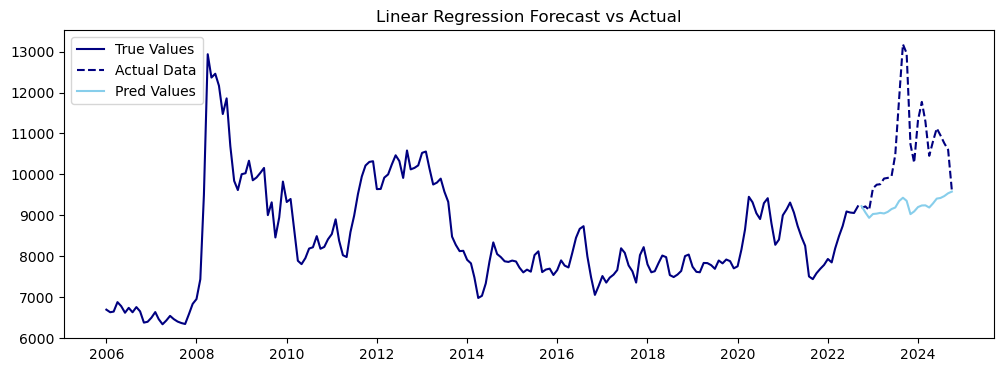

In [22]:
# Plot predictions
plt.figure(figsize=(12, 4))
plt.plot(y_train, c='navy', label='True Values')
plt.plot(y_test, c='navy', linestyle='dashed', label="Actual Data")
plt.plot(test_data.index,y_pred, c='skyblue', label='Pred Values')
plt.title("Linear Regression Forecast vs Actual")
plt.legend()

# saving the plot as an image
plt.savefig('../figure/hommali/Linear Regression Forecast vs Actual.png')
plt.show()

#### Feature importance

In [24]:
# print regression coefficients
lr_hommali_feature_importance = pd.DataFrame(zip(X.columns, lr.coef_))
lr_hommali_feature_importance

,0,1
0,hommali_price,0.229766
1,hommali_price_index,0.002990


## 2. ARIMA Model

### Model 2 : ARIMA

In [27]:
# Fit an ARIMA model with exogenous variables (also called ARIMAX)
y_train.index.freq = 'MS'
X_train.index.freq = 'MS'

arimax1_model = ARIMA(
    y_train,                 # Dependent variable (nonglu_price)
    exog=X_train,            # External variables 
    order=(2, 1, 2)).fit()   # ARIMA parameters: (p=2, d=1, q=2)

In [28]:
# Generate predictions on the test set
arimax1_forecast = arimax1_model.predict(
   start=X_test.index[0],    # Start forecasting from first test observation
   end=X_test.index[-1],     # Continue until last test observation
   exog=X_test)

In [29]:
# Evaluate the ARIMAX(2,1,2) Model
arimax1_mse = mean_squared_error(y_test, arimax1_forecast)
arimax1_rmse = root_mean_squared_error(y_test, arimax1_forecast)
arimax1_r2 = r2_score(y_test, arimax1_forecast)

print(f"ARIMAX(2,1,2) Model MSE : {arimax1_mse:.4f}")
print(f"ARIMAX(2,1,2) Model RMSE :{arimax1_rmse:.4f}")
print(f"ARIMAX(2,1,2) Model R-squared :{arimax1_r2:.4f}")

ARIMAX(2,1,2) Model MSE : 2559211.1867
ARIMAX(2,1,2) Model RMSE :1599.7535
ARIMAX(2,1,2) Model R-squared :-1.3271


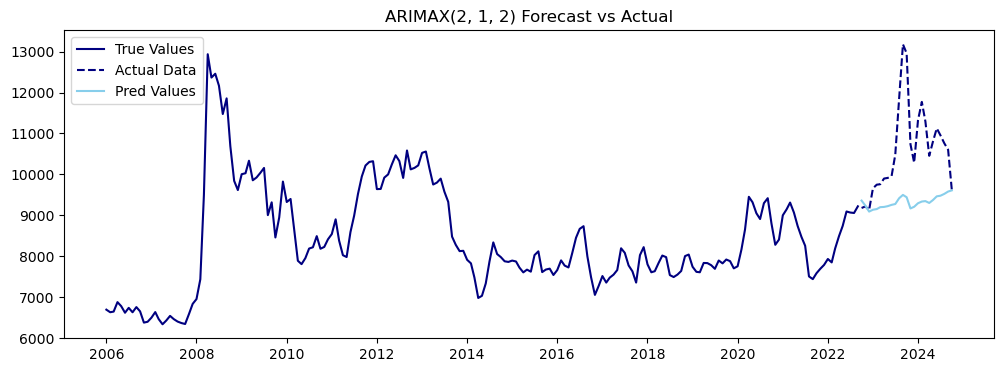

In [30]:
# Plot 
plt.figure(figsize=(12, 4))
plt.plot(y_train, c='navy', label='True Values')
plt.plot(y_test, c='navy', linestyle='dashed', label="Actual Data")
plt.plot(arimax1_forecast, c='skyblue', label='Pred Values')
plt.title("ARIMAX(2, 1, 2) Forecast vs Actual")
plt.legend()

# saving the plot as an image
plt.savefig('../figure/hommali/ARIMAX(2,1,2) Forecast vs Actual.png')
plt.show()

#### Feature Importance

In [32]:
arimax1_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           nonglu_price   No. Observations:                  201
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1450.903
Date:                Thu, 19 Dec 2024   AIC                           2923.805
Time:                        14:07:51   BIC                           2960.087
Sample:                    01-01-2006   HQIC                          2938.488
                         - 09-01-2022                                         
Covariance Type:                  opg                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
hommali_price           0.1846      0.075      2.449      0.014       0.037       0.332
hommali_price_index     0.0024      3.818      0.001      0.999      -7.481       7.486
shock_event_1          37.4362   1231.949      0.030      0.976   -2377.140    2452.012
shock_event_2        2843.2821    622.700      4.566      0.000    1622.812    4063.752
shock_event_3           9.4259   2009.152      0.005      0.996   -3928.440    3947.292
shock_event_4                0      3.846          0      1.000      -7.537       7.537
ar.L1                   0.7880      0.144      5.480      0.000       0.506       1.070
ar.L2                  -0.8296      0.136     -6.087      0.000      -1.097      -0.562
ma.L1                  -0.7106      0.186     -3.815      0.000      -1.076      -0.346
ma.L2                   0.6987      0.165      4.238      0.000       0.376       1.022
sigma2               1.232e+05   1.03e+04     12.004      0.000    1.03e+05    1.43e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               214.68
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.32   Skew:                             0.22
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.15e+23. Standard errors may be unstable.
"""

### Model 3 : Auto ARIMA

In [34]:
# Automatically tune ARIMA parameters
auto_model = auto_arima(
    y_train,exogenous=X_train,
    start_p=0, max_p=4,
    start_q=0, max_q=4,
    d=None,seasonal=False, trace=False,error_action='ignore', suppress_warnings=True, stepwise=True)

# Best parameters
print(auto_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  201
Model:               SARIMAX(2, 0, 0)   Log Likelihood               -1497.527
Date:                Thu, 19 Dec 2024   AIC                           3003.053
Time:                        14:07:51   BIC                           3016.267
Sample:                    01-01-2006   HQIC                          3008.400
                         - 09-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    675.8081    219.037      3.085      0.002     246.504    1105.112
ar.L1          1.2125      0.031     39.511      0.000       1.152       1.273
ar.L2         -0.2931      0.038     -7.801      0.0

In [35]:
# Fit an ARIMA model with exogenous variables (also called ARIMAX)
y_train.index.freq = 'MS'
X_train.index.freq = 'MS'

arimax2_model = ARIMA(
    y_train,           # Dependent variable (nonglu_price)
    exog = X_train,    # External variables 
    order = (2, 0, 0), # ARIMA parameters: (p=2, d=0, q=0)
).fit()

# Get the residual
arimax2_model_residuals = arimax2_model.resid

# Generate predictions on the test set
arimax2_forecast = arimax2_model.predict(
   start=X_test.index[0],    # Start forecasting from first test observation
   end=X_test.index[-1],     # Continue until last test observation
   exog=X_test)

In [36]:
# Evaluate the ARIMAX(2,0,0) Model
arimax2_mse = mean_squared_error(y_test, arimax2_forecast)
arimax2_rmse = root_mean_squared_error(y_test, arimax2_forecast)
arimax2_r2 = r2_score(y_test, arimax2_forecast)

print(f"ARIMAX(2,0,0) Model MSE : {arimax2_mse:.4f}")
print(f"ARIMAX(2,0,0) Model RMSE :{arimax2_rmse:.4f}")
print(f"ARIMAX(2,0,0) Model R-squared :{arimax2_r2:.4f}")

ARIMAX(2,0,0) Model MSE : 2542351.3719
ARIMAX(2,0,0) Model RMSE :1594.4753
ARIMAX(2,0,0) Model R-squared :-1.3118


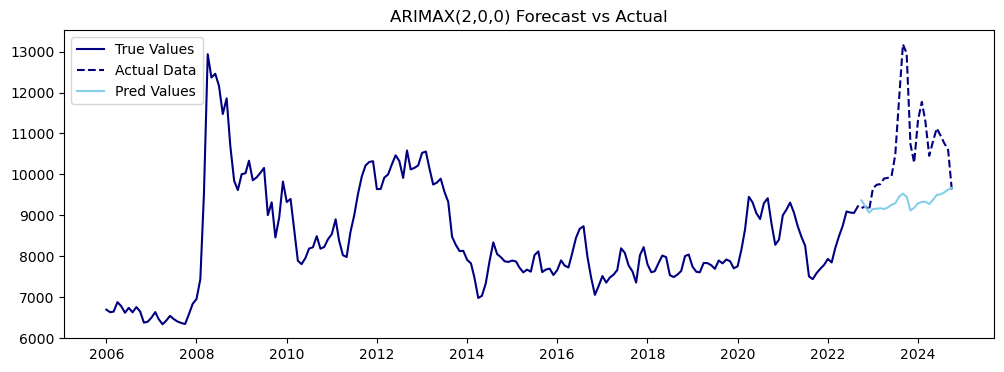

In [37]:
# Plot 
plt.figure(figsize=(12, 4))
plt.plot(y_train, c='navy', label='True Values')
plt.plot(y_test, c='navy', linestyle='dashed', label="Actual Data")
plt.plot(arimax2_forecast, c='skyblue', label='Pred Values')
plt.title("ARIMAX(2,0,0) Forecast vs Actual")
plt.legend()

# saving the plot as an image
plt.savefig('../figure/hommali/ARIMAX(2,0,0) Forecast vs Actual.png')
plt.show()

#### Feature Importance

In [39]:
arimax2_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           nonglu_price   No. Observations:                  201
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -1479.399
Date:                Thu, 19 Dec 2024   AIC                           2978.798
Time:                        14:07:52   BIC                           3011.831
Sample:                    01-01-2006   HQIC                          2992.164
                         - 09-01-2022                                         
Covariance Type:                  opg                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                4625.4645    805.869      5.740      0.000    3045.990    6204.939
hommali_price           0.2354      0.056      4.237      0.000       0.127       0.344
hommali_price_index     0.0031      0.001      4.171      0.000       0.002       0.005
shock_event_1         653.2421    242.607      2.693      0.007     177.741    1128.743
shock_event_2         314.1755    172.956      1.817      0.069     -24.812     653.163
shock_event_3         382.2478    406.608      0.940      0.347    -414.688    1179.184
shock_event_4                0    1.2e-11          0      1.000   -2.36e-11    2.36e-11
ar.L1                   1.0873      0.060     18.138      0.000       0.970       1.205
ar.L2                  -0.1820      0.065     -2.795      0.005      -0.310      -0.054
sigma2               1.447e+05   1.11e+04     13.039      0.000    1.23e+05    1.66e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):               373.24
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               0.29   Skew:                             1.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.38e+30. Standard errors may be unstable.
"""

## 4. GARCH Model

### Model 4 : GARCH

In [42]:
# Seed pseudorandom number generator
seed(1)

# Define model - fit on the residuals.
garch_model = arch_model(arimax2_model_residuals,mean='HARX', vol='GARCH', p=1, q=1, rescale=False)

# Fit model
garch_model_fit = garch_model.fit(disp='off')

# forecast the test set
garch_forecast = garch_model_fit.forecast(horizon=len(y_test), reindex=False)
garch_volatility = np.sqrt(garch_forecast.variance.values[-1])  # Convert to standard deviation

arimax_forecast = arimax2_model.get_forecast(steps=len(y_test), exog=X_test)
arimax_mean = arimax_forecast.predicted_mean

# combine ARIMAX Mean and GARCH Volatility
yhat = arimax_mean + garch_volatility  # Add GARCH volatility directly

In [43]:
# Evaluate the GARCH Model
garch_mse = mean_squared_error(y_test, yhat)
garch_rmse = root_mean_squared_error(y_test, yhat)
garch_r2 = r2_score(y_test, yhat)
print(f"GARCH Model MSE : {garch_mse:.4f}")
print(f"GARCH Model RMSE :{garch_rmse:.4f}")
print(f"GARCH Model R-squared :{garch_r2:.4f}")

GARCH Model MSE : 1749356.4075
GARCH Model RMSE :1322.6324
GARCH Model R-squared :-0.5907


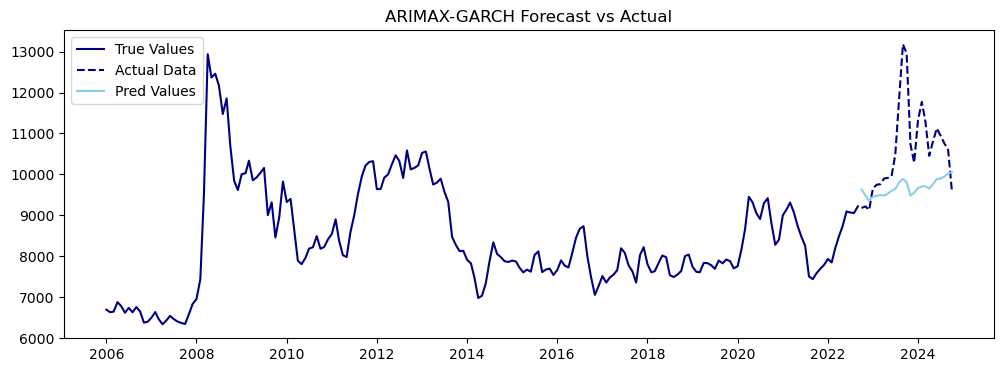

In [44]:
plt.figure(figsize=(12, 4))
plt.plot(y_train, c='navy', label="True Values")
plt.plot(y_test.index, y_test, c='navy', linestyle='dashed', label="Actual Data")
plt.plot(y_test.index, yhat, c='skyblue', label="Pred Values")
plt.legend()
plt.title("ARIMAX-GARCH Forecast vs Actual")

# saving the plot as an image
plt.savefig('../figure/hommali/ARIMAX-GARCH Forecast vs Actual.png')
plt.show()

#### Feature importance

In [46]:
print('GARCH Coefficients:')
print('omega (constant):', garch_model_fit.params['omega'])
print('alpha (ARCH term):', garch_model_fit.params['alpha[1]'])
print('beta (GARCH term):', garch_model_fit.params['beta[1]'])

GARCH Coefficients:
omega (constant): 14360.056601401127
alpha (ARCH term): 0.25223205371962404
beta (GARCH term): 0.6586501338480566


# Compare Model Evaluation

In [48]:
# Create score Dataframe
score_df = pd.DataFrame(data = {'feature' : ['hommali'] * 3,
                                'model': ['Linear','ARIMAX(2,0,0)','GARCH'] , 
                                'MSE': [lr_mse,arimax2_mse,garch_mse], 
                                'RMSE': [lr_rmse,arimax2_rmse,garch_rmse], 
                                'R2': [lr_r2,arimax2_r2,garch_r2]})
score_df.to_csv('../data/cleaned_data/evaluation/hommali_evaluation.csv', index=False)
score_df

,feature,model,MSE,RMSE,R2
0,hommali,Linear,2.792925e+06,1671.204552,-1.539603
1,hommali,"ARIMAX(2,0,0)",2.542351e+06,1594.475265,-1.311757
2,hommali,GARCH,1.749356e+06,1322.632378,-0.590687
